In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
print(f"DiFPTe available: {'MPS' if torch.backends.mps.is_available() else 'CPU'}")


DiFPTe available: MPS


In [2]:
df = pd.read_csv("./data/FPT_train.csv")

df["time"] = pd.to_datetime(df["time"])
df = df.sort_values("time").reset_index(drop=True)
df["close_log"] = np.log(df["close"])


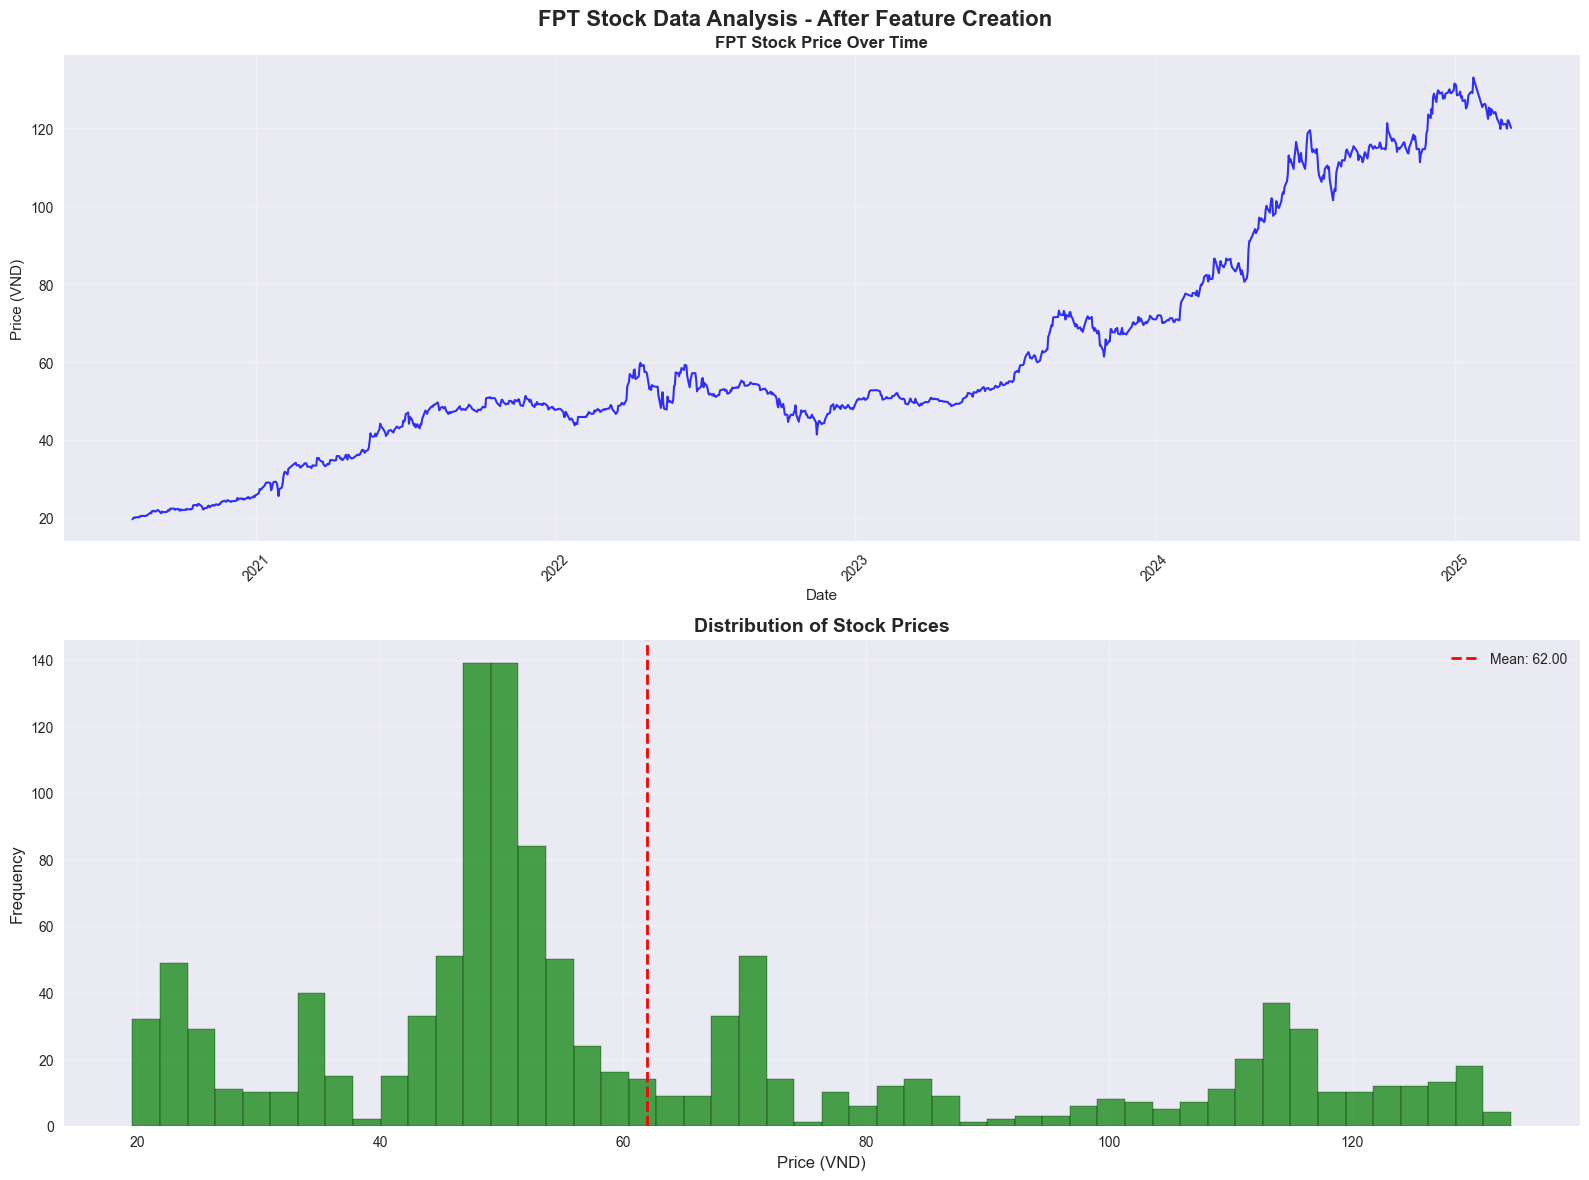

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle(
    "FPT Stock Data Analysis - After Feature Creation", fontsize=16, fontweight="bold"
)

# 1) Stock Price Over Time
axes[0].plot(df["time"], df["close"], linewidth=1.5, color="blue", alpha=0.8)
axes[0].set_title("FPT Stock Price Over Time", fontsize=12, fontweight="bold")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price (VND)")
axes[0].grid(True, alpha=0.3)
axes[0].tick_params(axis="x", rotation=45)

# Plot 2: Phân phối giá
axes[1].hist(df["close"], bins=50, color="green", alpha=0.7, edgecolor="black")
axes[1].set_title("Distribution of Stock Prices", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Price (VND)", fontsize=12)
axes[1].set_ylabel("Frequency", fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axvline(
    df["close"].mean(),
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Mean: {df['close'].mean():.2f}",
)
axes[1].legend()

plt.tight_layout()
plt.show()

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, output_len, target_col="close_log"):
        self.data = data[target_col].values
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - self.input_len - self.output_len + 1

    def __getitem__(self, idx):
        x = self.data[idx : idx + self.input_len]
        y = self.data[idx + self.input_len : idx + self.input_len + self.output_len]
        return torch.FloatTensor(x), torch.FloatTensor(y)


In [5]:
class Linear(nn.Module):
    """Simple Linear model for univariate time series forecasting"""

    def __init__(self, seq_len, pred_len):
        super(Linear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        return self.linear(x)


class DLinear(nn.Module):
    def __init__(self, seq_len, pred_len=15, moving_avg=5):
        super(DLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.moving_avg = min(moving_avg, seq_len - 1)

        self.linear_trend = nn.Linear(seq_len, pred_len)
        self.linear_seasonal = nn.Linear(seq_len, pred_len)

        self.register_buffer(
            "avg_kernel", torch.ones(1, 1, self.moving_avg) / self.moving_avg
        )

    def decompose(self, x):
        batch_size, seq_len = x.shape
        x_reshaped = x.unsqueeze(1)

        padding = self.moving_avg // 2
        x_padded = torch.nn.functional.pad(
            x_reshaped, (padding, padding), mode="replicate"
        )

        trend = torch.nn.functional.conv1d(x_padded, self.avg_kernel, padding=0)
        trend = trend.squeeze(1)

        if trend.shape[1] != seq_len:
            trend = torch.nn.functional.interpolate(
                trend.unsqueeze(1), size=seq_len, mode="linear", align_corners=False
            ).squeeze(1)

        seasonal = x - trend
        return trend, seasonal

    def forward(self, x):
        trend, seasonal = self.decompose(x)
        trend_pred = self.linear_trend(trend)
        seasonal_pred = self.linear_seasonal(seasonal)
        return trend_pred + seasonal_pred


class NLinear(nn.Module):
    def __init__(self, seq_len, pred_len=15):
        super(NLinear, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.linear = nn.Linear(seq_len, pred_len)

    def forward(self, x):
        last_value = x[:, -1:]
        x_normalized = (x - last_value) / last_value
        pred_normalized = self.linear(x_normalized)
        pred = pred_normalized * last_value + last_value
        return pred


print("LTSF-Linear models implemented cho dự báo 15 ngày.")

LTSF-Linear models implemented cho dự báo 15 ngày.


In [6]:
# Create datasets cho bài toán dự báo 5 ngày với các độ dài cửa sổ khác nhau
seq_length = 15  # input_len 15 ngày
pred_len = 5  # dự báo cho 5 ngày tiếp theo (output len)

# Create datasets and train_loader
dataset = TimeSeriesDataset(df, seq_length, pred_len)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [7]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = NLinear(seq_length, pred_len)

num_epochs = 50
model.to(device)

NLinear(
  (linear): Linear(in_features=15, out_features=5, bias=True)
)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []

for epoch in range(num_epochs):
    # Train
    model.train()
    epoch_train = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train += loss.item()
    train_losses.append(epoch_train / max(1, len(train_loader)))
    if (epoch + 1) % 5 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_losses[-1]:.6f}")


Epoch [5/50], Loss: 0.032578
Epoch [10/50], Loss: 0.002908
Epoch [15/50], Loss: 0.001165
Epoch [20/50], Loss: 0.000919
Epoch [25/50], Loss: 0.000876
Epoch [30/50], Loss: 0.000845
Epoch [35/50], Loss: 0.000848
Epoch [40/50], Loss: 0.000819
Epoch [45/50], Loss: 0.000834
Epoch [50/50], Loss: 0.000811


In [9]:
initial_input = df["close_log"].values[-seq_length:].copy()
current_input = initial_input.copy()

TOTAL_PREDICT_DAYS = 100
# Dự đoán iterative: 14 -> 3 -> 3 -> ... cho đến 100 ngày
model.eval()
all_predictions_log = []

# Bắt đầu với input ban đầu
current_input = initial_input.copy()

with torch.no_grad():
    remaining_days = TOTAL_PREDICT_DAYS

    while remaining_days > 0:
        # Số ngày cần dự đoán trong lần này
        predict_this_step = min(pred_len, remaining_days)

        # Dự đoán
        input_tensor = torch.FloatTensor(current_input).unsqueeze(0).to(device)
        output = model(input_tensor)
        predictions = output[0].cpu().numpy()[:predict_this_step]

        # Lưu predictions
        all_predictions_log.extend(predictions)

        # Cập nhật input cho lần tiếp theo: bỏ INPUT_LEN - OUTPUT_LEN ngày đầu, thêm predictions
        current_input = np.concatenate(
            [
                current_input[pred_len:],  # Bỏ OUTPUT_LEN ngày đầu
                predictions,  # Thêm predictions mới
            ]
        )

        remaining_days -= predict_this_step
        if (remaining_days) % 5 == 0:
            print(f"Prediction at {remaining_days}: {predictions}")

Prediction at 95: [4.7940707 4.7933545 4.79446   4.807341  4.797178 ]
Prediction at 90: [4.7991076 4.8012123 4.795807  4.80518   4.804324 ]
Prediction at 85: [4.8045483 4.807671  4.8035107 4.8148565 4.8149605]
Prediction at 80: [4.8164616 4.8166456 4.818368  4.8253574 4.8225884]
Prediction at 75: [4.824529  4.825496  4.8276772 4.8336573 4.8310857]
Prediction at 70: [4.833392  4.8338633 4.8361425 4.840311  4.838998 ]
Prediction at 65: [4.841022  4.8424244 4.8432803 4.8486786 4.847876 ]
Prediction at 60: [4.8497806 4.851305  4.8521233 4.857088  4.856526 ]
Prediction at 55: [4.8583193 4.860117  4.860846  4.8659897 4.865489 ]
Prediction at 50: [4.8674445 4.868853  4.870089  4.8747816 4.874119 ]
Prediction at 45: [4.876109  4.8775663 4.8787737 4.88356   4.8828917]
Prediction at 40: [4.884901  4.8863277 4.8875575 4.892184  4.891618 ]
Prediction at 35: [4.8935823 4.895141  4.8962264 4.900991  4.900482 ]
Prediction at 30: [4.902451 4.903993 4.905111 4.909822 4.909308]
Prediction at 25: [4.9112

In [10]:
# Chuyển đổi từ log về giá close
predictions_close = np.exp(all_predictions_log)

# Id: 100 số nguyên liên tiếp từ 1 đến 100
prediction_ids = list(range(1, TOTAL_PREDICT_DAYS + 1))


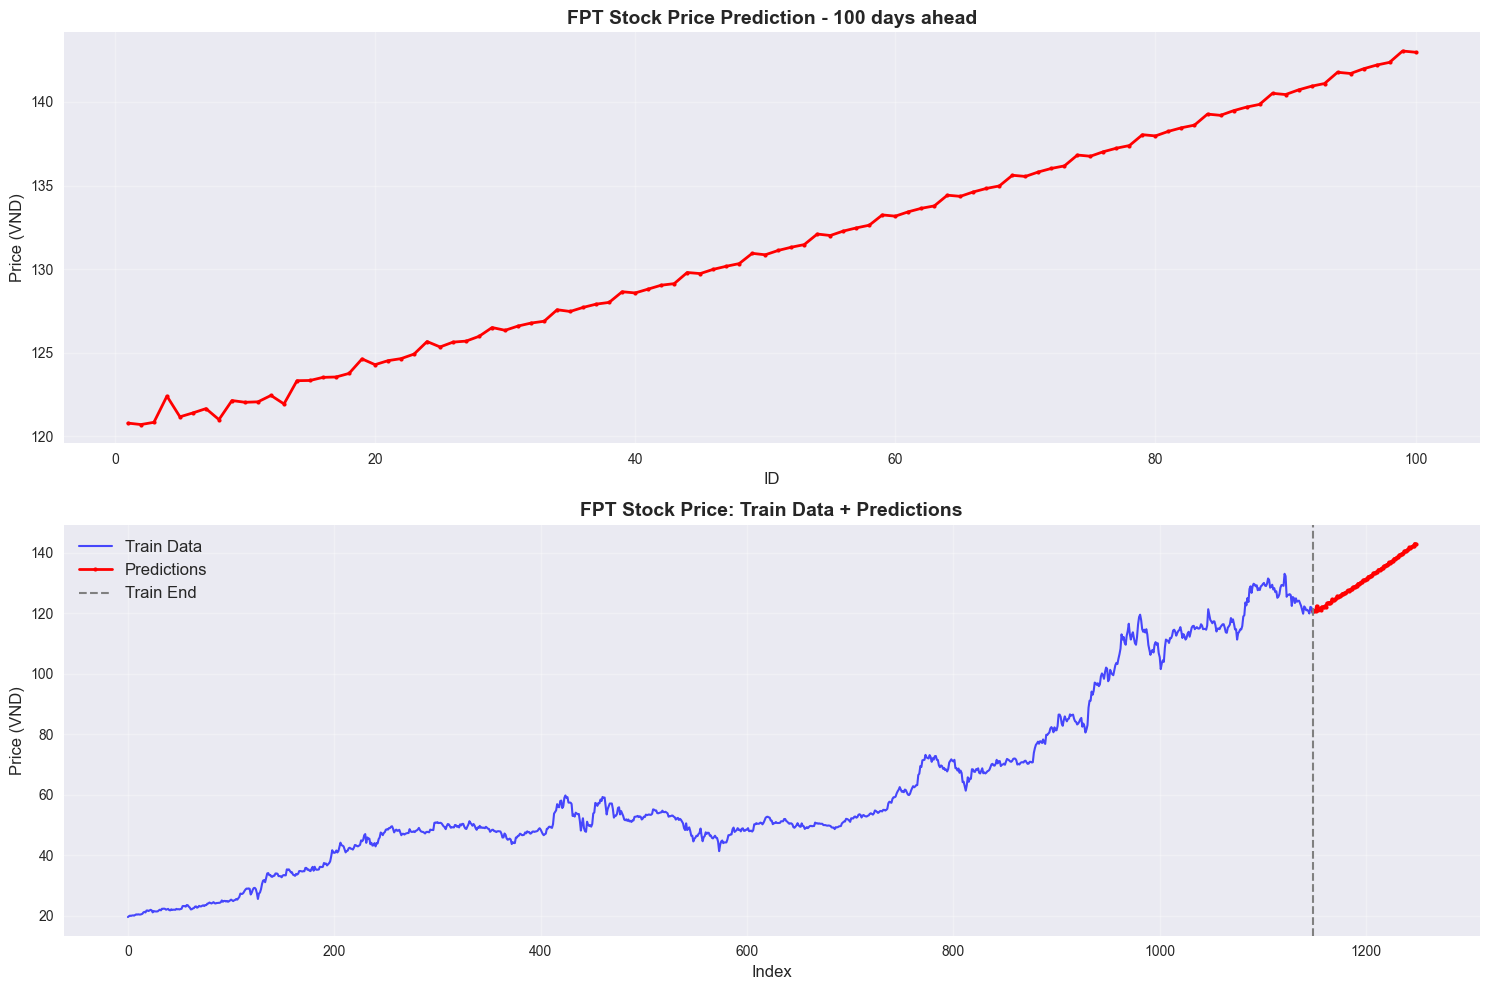

In [11]:
# Visualization kết quả dự đoán
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Dự đoán 100 ngày tiếp theo
axes[0].plot(
    prediction_ids,
    predictions_close,
    linewidth=2,
    color="red",
    marker="o",
    markersize=3,
)
axes[0].set_title(
    f"FPT Stock Price Prediction - {TOTAL_PREDICT_DAYS} days ahead",
    fontsize=14,
    fontweight="bold",
)
axes[0].set_xlabel("ID", fontsize=12)
axes[0].set_ylabel("Price (VND)", fontsize=12)
axes[0].grid(True, alpha=0.3)

# Plot 2: Kết hợp train data và predictions
last_train_idx = len(df)
axes[1].plot(
    range(len(df)),
    df["close"],
    linewidth=1.5,
    color="blue",
    alpha=0.7,
    label="Train Data",
)
axes[1].plot(
    range(last_train_idx, last_train_idx + TOTAL_PREDICT_DAYS),
    predictions_close,
    linewidth=2,
    color="red",
    marker="o",
    markersize=3,
    label="Predictions",
)
axes[1].axvline(
    last_train_idx, color="gray", linestyle="--", linewidth=1.5, label="Train End"
)
axes[1].set_title(
    "FPT Stock Price: Train Data + Predictions", fontsize=14, fontweight="bold"
)
axes[1].set_xlabel("Index", fontsize=12)
axes[1].set_ylabel("Price (VND)", fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# Tạo file CSV output với format: id, close
output_df = pd.DataFrame({
    'id': prediction_ids,
    'close': predictions_close
})

# Lưu file CSV
output_filename = 'NLinear_submission.csv'
output_df.to_csv(output_filename, index=False)
print(f"Đã lưu file: {output_filename}")

Đã lưu file: NLinear_submission.csv
